# Phase 1: Setup & Data Exploration
## Facial Expression Recognition - CK+ Dataset

**Goal:** Load, explore, and preprocess the CK+ dataset for facial expression classification.

**Emotions to classify:**
1. Happy (1)
2. Fear (2)
3. Surprise (3)
4. Anger (4)
5. Disgust (5)
6. Sadness (6)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path

np.random.seed(42)

#pd.set_option('display.max_columns', None)
#plt.rcParams['figure.figsize'] = (12, 6)

## Explore Dataset Structure 

In [2]:
ck_plus_path = 'CK+_lands/CK+'

print("Dataset structure:")
print("="*50)

# List all subject folders
subject_folders = sorted([d for d in os.listdir(ck_plus_path) 
                           if os.path.isdir(os.path.join(ck_plus_path, d)) 
                           and d.startswith('S')])

print(f"Found {len(subject_folders)} subjects:  {subject_folders[: 5]}... ")
print()

# Show an example of one subject's structure
example_subject = subject_folders[0]
example_path = os.path.join(ck_plus_path, example_subject)
files_in_subject = os.listdir(example_path)
print(f"Example - {example_subject} contains: ")
for f in files_in_subject[: 5]:
    print(f"  - {f}")

Dataset structure:
Found 123 subjects:  ['S005', 'S010', 'S011', 'S014', 'S022']... 

Example - S005 contains: 
  - omlands.csv


## Load Emotion Mapping

Load the emotion. csv file to understand the labels.

In [3]:
emotion_file = 'CK+_lands/CK+/emotion.csv'

emotions_df = pd.read_csv(emotion_file, sep=';', header=0) 
emotions_df.columns = ['Subject', 'Session', 'Emotion']

print("Emotion mapping file: ")
print(f"\nTotal records: {len(emotions_df)}")
print(f"\nEmotion distribution:")
print(emotions_df['Emotion'].value_counts().sort_index())

emotion_names = {
    1: 'Happy',
    2: 'Fear',
    3: 'Surprise',
    4: 'Anger',
    5: 'Disgust',
    6: 'Sadness'
}

print("\nEmotion names:")
for code, name in emotion_names.items():
    count = (emotions_df['Emotion'] == code).sum()
    print(f"  {code}: {name} ({count})")

Emotion mapping file: 

Total records: 357

Emotion distribution:
Emotion
1    94
2    53
3    77
4    36
5    38
6    59
Name: count, dtype: int64

Emotion names:
  1: Happy (94)
  2: Fear (53)
  3: Surprise (77)
  4: Anger (36)
  5: Disgust (38)
  6: Sadness (59)


In [4]:
emotions_df.head(10)

,Subject,Session,Emotion
0,S005,1,5
1,S010,1,2
2,S010,2,3
3,S010,3,6
4,S010,4,4
5,S010,5,5
6,S010,6,1
7,S011,1,3
8,S011,2,6
9,S011,3,2


## Load Facial Points 

Load the omlands.csv files for each subject and combine them.

In [25]:
inconsistent_column_counts = [] #list to track subjects if there are missing points in the subject's session data

def load_facialPoints_for_subject(subject_id, base_path='CK+_lands/CK+'):
    """
    Loads 68 facial landmarks from a CSV file, handling trailing delimiters.
    """
    file_path = Path(base_path) / subject_id / 'omlands.csv'
    
    if not file_path.exists():
        print(f"Warning: {file_path} not found")
        return None
    
    df = pd.read_csv(file_path, sep=';', header=None)
    
    # Adjust the shape of the dataframe by deleting the empty element after the last semicolon
    if df.shape[1] == 138:
        df = df.iloc[:, :-1]
        
    # If the subject's facial point number is incorrect, add to inconsistent_column_counts list
    if df.shape[1] != 137:
        inconsistent_column_counts.append({
            'subject': subject_id, 'found': df.shape[1], 'expected': 137
        })
        print(f'subjects with inconsistent columns : {len(inconsistent_column_counts)}')
        return None

    # Name columns: [x1, y1, x2, y2...] 
    coords = [f'{axis}{i}' for i in range(1, 69) for axis in ['x', 'y']]
    df.columns = ['Session'] + coords
    
    df['Subject'] = subject_id
    
    return df

# Test with one subject 
test_subject = subject_folders[0]
test_facialPoints = load_facialPoints_for_subject(test_subject)

print(f"Sample data from {test_subject}:")
print(test_facialPoints.head())
print(f"\nShape: {test_facialPoints.shape}")
print(f"Columns: {test_facialPoints.columns.tolist()[:10]}...")  # Show first 10 columns

Sample data from S005:
   Session   x1   y1   x2   y2   x3   y3   x4   y4   x5  ...  y64  x65  y65  \
0        1  430  400  429  478  439  555  457  631  486  ...  669  829  676   
1        1  430  400  429  478  439  555  457  631  486  ...  669  829  676   
2        1  428  398  426  478  435  557  452  635  481  ...  668  829  675   
3        1  431  400  430  477  439  555  456  631  484  ...  667  829  675   
4        1  429  399  430  477  441  555  459  631  488  ...  665  828  672   

   x66  y66  x67  y67  x68  y68  Subject  
0  776  672  746  676  717  672     S005  
1  776  672  746  676  717  672     S005  
2  778  672  746  676  717  673     S005  
3  778  670  747  675  718  671     S005  
4  777  669  746  674  717  669     S005  

[5 rows x 138 columns]

Shape: (12, 138)
Columns: ['Session', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'x5']...


## Build Complete Dataset

Combine all subjects and match facial points with their corresponding emotions.

In [28]:
# Load facial points for all subjects
all_facialPoints = []
failed_subjects = []

for subject_id in subject_folders:
    facialPoints = load_facialPoints_for_subject(subject_id)
    if facialPoints is not None:
        all_facialPoints.append(facialPoints)
    else:
        failed_subjects.append(subject_id)

# Combine all into one DataFrame
facialPoints_df = pd.concat(all_facialPoints, ignore_index=True)
print(f"Total samples: {len(facialPoints_df)}")
print(f"Total features: {facialPoints_df.shape[1]}")

# Remove trailing spaces from column names
facialPoints_df.columns = facialPoints_df.columns.str.strip()

Total samples: 10810
Total features: 138


In [30]:
# Ensure session and subject column has the same format to easily merge
emotions_df['Subject_Clean'] = emotions_df['Subject'].str.strip()
emotions_df['Session_Clean'] = emotions_df['Session'].astype(str).str.zfill(3)
facialPoints_df['Subject_Clean'] = facialPoints_df['Subject'].str.strip()
facialPoints_df['Session_Clean'] = facialPoints_df['Session'].astype(str).str.zfill(3)

# Merge on subject and session
data = facialPoints_df.merge(
    emotions_df[['Subject_Clean', 'Session_Clean', 'Emotion']], 
    on=['Subject_Clean', 'Session_Clean'], 
    how='left'
)

print("Merged dataset: ")
print(data.head())
print(f"\nShape: {data.shape}")

# Check for unmatched records
unmatched = data['Emotion'].isna().sum()
print(f"\nUnmatched records (no emotion label): {unmatched}")

# Remove unmatched records
data = data.dropna(subset=['Emotion'])
data['Emotion'] = data['Emotion'].astype(int)

print(f"Final dataset size: {len(data)}")
print(f"\nEmotion distribution:")
emotion_counts = data['Emotion']. value_counts().sort_index()
for emotion_code, count in emotion_counts. items():
    emotion_name = emotion_names. get(emotion_code, 'Unknown')
    print(f"  {emotion_code} ({emotion_name}): {count} samples")

Merged dataset: 
   Session   x1   y1   x2   y2   x3   y3   x4   y4   x5  ...  x66  y66  x67  \
0        1  430  400  429  478  439  555  457  631  486  ...  776  672  746   
1        1  430  400  429  478  439  555  457  631  486  ...  776  672  746   
2        1  428  398  426  478  435  557  452  635  481  ...  778  672  746   
3        1  431  400  430  477  439  555  456  631  484  ...  778  670  747   
4        1  429  399  430  477  441  555  459  631  488  ...  777  669  746   

   y67  x68  y68  Subject  Subject_Clean  Session_Clean  Emotion  
0  676  717  672     S005           S005            001      5.0  
1  676  717  672     S005           S005            001      5.0  
2  676  717  673     S005           S005            001      5.0  
3  675  718  671     S005           S005            001      5.0  
4  674  717  669     S005           S005            001      5.0  

[5 rows x 141 columns]

Shape: (10810, 141)

Unmatched records (no emotion label): 4204
Final dataset siz

In [31]:
data.head()

,Session,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x66,y66,x67,y67,x68,y68,Subject,Subject_Clean,Session_Clean,Emotion
0,1,430,400,429,478,439,555,457,631,486,...,776,672,746,676,717,672,S005,S005,001,5
1,1,430,400,429,478,439,555,457,631,486,...,776,672,746,676,717,672,S005,S005,001,5
2,1,428,398,426,478,435,557,452,635,481,...,778,672,746,676,717,673,S005,S005,001,5
3,1,431,400,430,477,439,555,456,631,484,...,778,670,747,675,718,671,S005,S005,001,5
4,1,429,399,430,477,441,555,459,631,488,...,777,669,746,674,717,669,S005,S005,001,5


In [34]:
data.shape

(6606, 141)

## Data Validation and Statistics

Check for missing values and get basic statistics.

In [38]:
# Check for missing values
print("Missing values check: ")
missing_by_col = data.isnull().sum()
missing_cols = missing_by_col[missing_by_col > 0]

if len(missing_cols) > 0:
    print(missing_cols)
else:
    print(" No missing values! ")

# Get facial point columns (exclude metadata or subject_id)
facialPoint_cols = [col for col in data. columns if col. startswith('x') or col.startswith('y')]

print(f"\nFacial Point statistics:")
print(f"  Total facial point coordinates: {len(facialPoint_cols)}")
print(f"  Which represents:  {len(facialPoint_cols) // 2} facial points")

# Display basic stats for Facial Points
facialPoints_stats = data[facialPoint_cols].describe()
print(f"\nSample statistics (first 4 facial points):")
print(facialPoints_stats.iloc[:, :8])  # Show first 8 coordinates

# Unique subjects
print(f"\nDataset composition:")
print(f"  Unique subjects:  {data['Subject_Clean'].nunique()}")
print(f"  Total samples: {len(data)}")
print(f"  Samples per emotion:")
print(data['Emotion'].value_counts().sort_index())

Missing values check: 
 No missing values! 

Facial Point statistics:
  Total facial point coordinates: 136
  Which represents:  68 facial points

Sample statistics (first 4 facial points):
                x1           y1           x2           y2           x3  \
count  6606.000000  6606.000000  6606.000000  6606.000000  6606.000000   
mean    404.397366   413.430366   408.684983   471.523766   417.239025   
std      59.851279    46.622016    59.406555    45.708423    58.950025   
min     256.000000   290.000000   264.000000   355.000000   274.000000   
25%     365.000000   383.000000   370.000000   442.000000   378.000000   
50%     396.000000   412.000000   400.500000   471.000000   407.000000   
75%     437.000000   452.000000   439.000000   507.000000   445.000000   
max     637.000000   543.000000   640.000000   594.000000   645.000000   

                y3           x4           y4  
count  6606.000000  6606.000000  6606.000000  
mean    528.983500   427.807296   586.432334  
st

**Analysis** : After merging all the samples (session data) from all the subjects, we find 99 unique subjects. Earlier by iterating the CK+ folder, I found 123 subject folders. This means that 24 subjects didn't have emotion data on the emotions_df (extracted from emotions.csv). Since the main foal to to predict emotion for a sample, I thought it was best to eliminate any sample that doesn't have its' corresponding emotion.

So after the cleanup, we have a total of 6606 samples for 99 subjects. Sample count per emotion varies from 1882 to 777.

## Visualize Facial points

Plot some sample faces to verify data integrity.

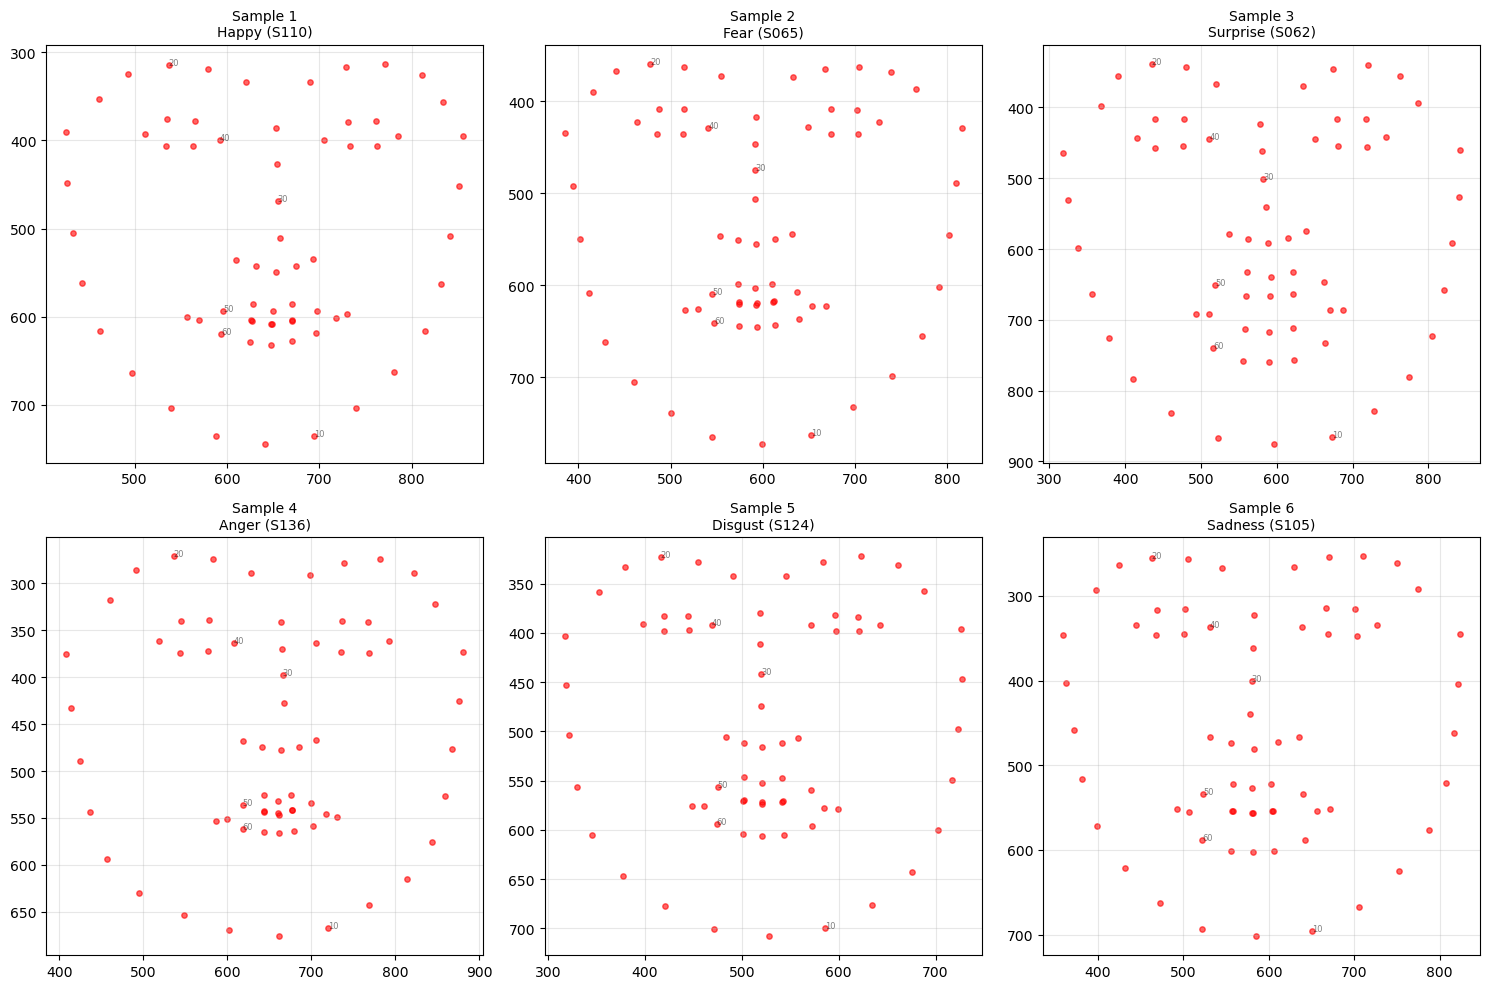

In [42]:
def plot_on_axis(ax, row, emotion_names, title=""):
    """
    Plots facial points onto a specific Matplotlib axis (ax).
    """
    xs = np.array([row[f'x{i}'] for i in range(1, 69)])
    ys = np.array([row[f'y{i}'] for i in range(1, 69)])
    
    # Plot on the provided axis (ax) instead of a new figure
    ax.scatter(xs, ys, c='red', s=15, alpha=0.6)
    
    # Add point numbers
    for i, (x, y) in enumerate(zip(xs, ys), 1):
        if i % 10 == 0: 
            ax.text(x, y, str(i), fontsize=6, alpha=0.5)
    
    emotion_code = int(row['Emotion'])
    emotion_name = emotion_names.get(emotion_code, 'Unknown')
    
    ax.set_title(f"{title}\n{emotion_name} ({row['Subject_Clean']})", fontsize=10)
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3)

# Grid Creation Logic

# Setup the figure and a 3x2 grid of axes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten() # Flatten 2D array (3,2) to 1D (6,) for easy looping

# Get the unique emotions
unique_emotions = sorted(data['Emotion'].unique())

for i, emotion_code in enumerate(unique_emotions):
    if i >= 6: break
    
    # Get a random sample for this emotion
    sample = data[data['Emotion'] == emotion_code].sample(1).iloc[0]
    
    # Plot on the i-th axis
    plot_on_axis(axes[i], sample, emotion_names, title=f"Sample {i+1}")

plt.tight_layout()
plt.show()

## Save Processed Data 

In [43]:
# Save raw data
data. to_csv('data_raw.csv', index=False)
print(" Saved:  data_raw.csv")

# Summary statistics
summary = {
    'total_samples': len(data),
    'total_features': len(facialPoint_cols),
    'num_facialPoints': len(facialPoint_cols) // 2,
    'emotion_names': emotion_names,
    'emotion_distribution': data['Emotion'].value_counts().to_dict(),
    'unique_subjects': data['Subject_Clean'].nunique()
}

print(f"\nDataset Summary:")
for key, value in summary.items():
    if key != 'emotion_names':
        print(f"  {key}:  {value}")

 Saved:  data_raw.csv

Dataset Summary:
  total_samples:  6606
  total_features:  136
  num_facialPoints:  68
  emotion_distribution:  {1: 1882, 3: 1359, 6: 1103, 2: 882, 4: 777, 5: 603}
  unique_subjects:  99
